In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

Hyperparameters for model and approximate inference

In [23]:
WEIGHT_DECAY = 5e-2
NB_SAMPLES = 400
TEXT_LOCATION = (-5,-7)

Plotting function

In [24]:
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
      if model_type=='classic':
          pred = model(test_tensor)
      elif model_type=='laplace':
          #Save original mean weight
          original_weight = model.state_dict()['fc.weight'].detach().clone()
          outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
          for i in range(nsamples):
              state_dict = model.state_dict()
              state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
              model.load_state_dict(state_dict)
              outputs[i] = net(test_tensor)
          pred = outputs.mean(0).squeeze()
          state_dict['fc.weight'] = original_weight
          model.load_state_dict(state_dict)
      elif model_type=='vi':
          outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
          for i in range(nsamples):
              outputs[i] = model(test_tensor)
          pred = outputs.mean(0).squeeze()
      elif model_type=='mcdropout':
          model.eval()
          model.training = True
          outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
          for i in range(nsamples):
              outputs[i] = model(test_tensor)
          pred = outputs.mean(0).squeeze()
    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

Loading our little dataset

In [25]:
X, y = make_blobs(n_samples=NB_SAMPLES, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

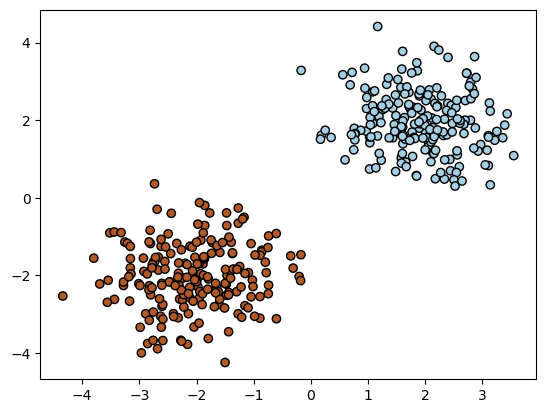

In [26]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

# I.1. Maximum-A-Posteriori Estimate

In [27]:
class LogisticRegression(nn.Module):
  """ A Logistic Regression Model with sigmoid output in Pytorch"""
  def __init__(self, input_size):
    super().__init__()
    self.fc = nn.Linear(input_size, 1)

  def forward(self, x):
    out = self.fc(x)
    return torch.sigmoid(out)

Train a Logistic Regression model with stochastic gradient descent for 20 epochs.

Epoch 20, Loss: 0.0082, Accuracy: 1.0000
Finished Training


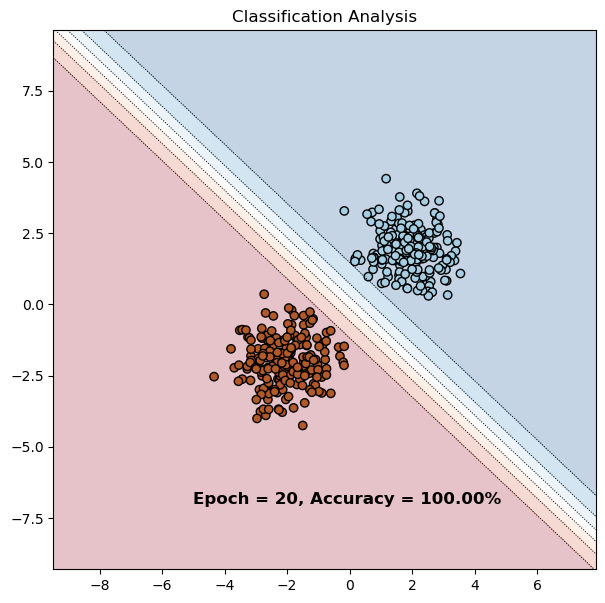

In [28]:
net = LogisticRegression(input_size=X.shape[1])
net.train()
criterion = nn.BCELoss()

# L2 regularization is included in Pytorch's optimizer implementation as "weigth_decay" option
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=WEIGHT_DECAY)

fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels.unsqueeze(1))

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    with torch.no_grad():
        output = net(X)
        predicted = (output >= 0.5).float()
        total = y.size(0)
        correct = (predicted.squeeze() == y).sum().item()
        accuracy = correct / total

    plot_decision_boundary(net, X.numpy(), y.numpy(), epoch, accuracy,
                           model_type='classic', tloc=TEXT_LOCATION)
    print(f'Epoch {epoch + 1}, Loss: {running_loss:.4f}, Accuracy: {accuracy:.4f}')

print('Finished Training')


# I.2. Laplace Approximation

In [29]:
# Extracting weights as μ_lap from the trained logistic regression model
w_map = net.state_dict()['fc.weight'].detach().numpy()

print("Extracted μ_lap (weights w_MAP):")
print(w_map)

Extracted μ_lap (weights w_MAP):
[[1.5392715 1.4836617]]


In [30]:
# Computing first derivative w.r.t to model's weights
optimizer.zero_grad()
output = net(X).squeeze()
loss = criterion(output, y) + net.fc.weight.norm()**2
gradf_weight = grad(loss, net.fc.weight, create_graph=True)[0]

# Compute the Hessian from the previous derivative
hess_weights = torch.zeros(net.fc.weight.shape[1], net.fc.weight.shape[1])

for i in range(net.fc.weight.shape[1]):
    grad2_weight = grad(gradf_weight[0, i], net.fc.weight, create_graph=True)[0]

    hess_weights[i] = grad2_weight.squeeze().detach()

# Add a small value to the diagonal before inverting to ensure numerical stability
I = torch.eye(hess_weights.shape[0])
Sigma_laplace = torch.inverse(hess_weights + 1e-4 * I).numpy()

print("Hessian Matrix:")
print(hess_weights)
print("Covariance Matrix (Sigma_laplace):")
print(Sigma_laplace)

Hessian Matrix:
tensor([[2.0163, 0.0118],
        [0.0118, 2.0165]])
Covariance Matrix (Sigma_laplace):
[[ 0.49595672 -0.00291056]
 [-0.00291054  0.49589333]]


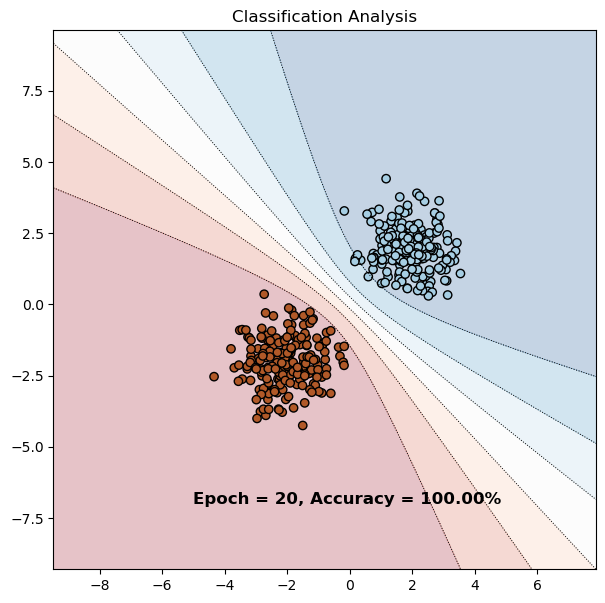

In [31]:
# Defining posterior distribution
laplace_posterior = np.random.multivariate_normal(w_map.reshape(2,), Sigma_laplace, NB_SAMPLES)

fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), model_type='laplace',
                       tloc=TEXT_LOCATION, nsamples=NB_SAMPLES, posterior=laplace_posterior)

# I.3. Variational Inference

In [32]:
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, parent):
        super().__init__()
        self.parent = parent

        if getattr(parent, 'accumulated_kl_div', None) is None:
            parent.accumulated_kl_div = 0

        self.w_mu = nn.Parameter(torch.zeros(output_size, input_size))
        self.w_rho = nn.Parameter(torch.ones(output_size, input_size))
        self.b_mu = nn.Parameter(torch.zeros(output_size))
        self.b_rho = nn.Parameter(torch.ones(output_size))

    def sampling(self, mu, rho):
        epsilon = torch.randn_like(mu)
        sigma = torch.log1p(torch.exp(rho))  # softplus to ensure positive standard deviation
        return mu + sigma * epsilon

    def kl_divergence(self, z, mu_theta, rho_theta, prior_sd=1):
        log_prior = dist.Normal(0, prior_sd).log_prob(z)
        log_p_q = dist.Normal(mu_theta, torch.log1p(torch.exp(rho_theta))).log_prob(z)
        return (log_p_q - log_prior).sum() / X.shape[0]

    def forward(self, x):
        w = self.sampling(self.w_mu, self.w_rho)
        b = self.sampling(self.b_mu, self.b_rho)
        out = F.linear(x, w, b)

        # Compute KL-div loss for training
        self.parent.accumulated_kl_div += self.kl_divergence(w, self.w_mu, self.w_rho)
        self.parent.accumulated_kl_div += self.kl_divergence(b, self.b_mu, self.b_rho)

        return out

Now, let's use this LinearVariational layer in a Logistic regression model.

In [33]:
class KL:
    accumulated_kl_div = 0

class VariationalLogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.kl_loss = KL
        self.fc_var =  LinearVariational(input_size, 1, self.kl_loss)

    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div

    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def forward(self, x):
        out = self.fc_var(x)
        return torch.sigmoid(out)


def elbo(input, target, model):
  negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
  return negative_log_likelihood + model.accumulated_kl_div

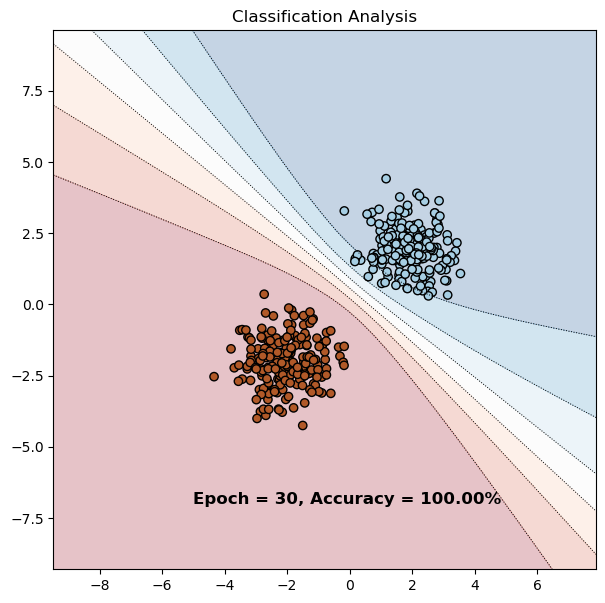

In [34]:
# We can now train our variational model as any other network in Pytorch

var_net = VariationalLogisticRegression(input_size=X.shape[1])
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1,  weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(30):
    optimizer.zero_grad()
    var_net.reset_kl_div()

    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()

    plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

# II. Bayesian Neural Networks

In [35]:
# Hyperparameters for model and approximate inference

NOISE_MOON = 0.05
WEIGHT_DECAY = 5e-2
NB_SAMPLES = 100
TEXT_LOCATION = (-1.5, -1.5)

NOISE_MOON = 0.3

from torch.utils import data as torch_data
from sklearn.datasets import make_moons

Let's load the two moons dataset

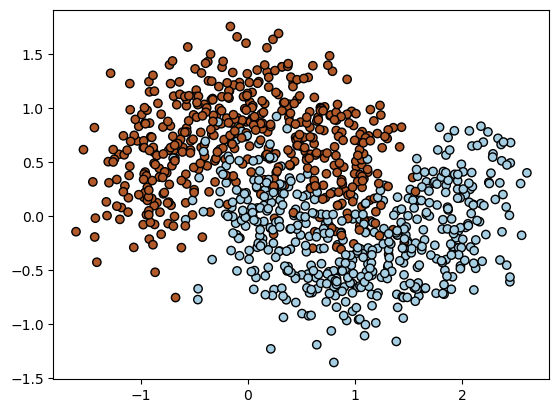

In [36]:
X, y = make_moons(n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = torch_data.TensorDataset(X, y)
train_dataloader = torch_data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

# II.1 Variational Inference with Bayesian Neural Networks

In [37]:
class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.kl_loss = KL()
        self.fc_hidden_var = LinearVariational(input_size, hidden_size, self.kl_loss)
        self.fc_out_var = LinearVariational(hidden_size, 1, self.kl_loss)

    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div

    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def forward(self, x):
        x = F.relu(self.fc_hidden_var(x))
        out = torch.sigmoid(self.fc_out_var(x))
        return out

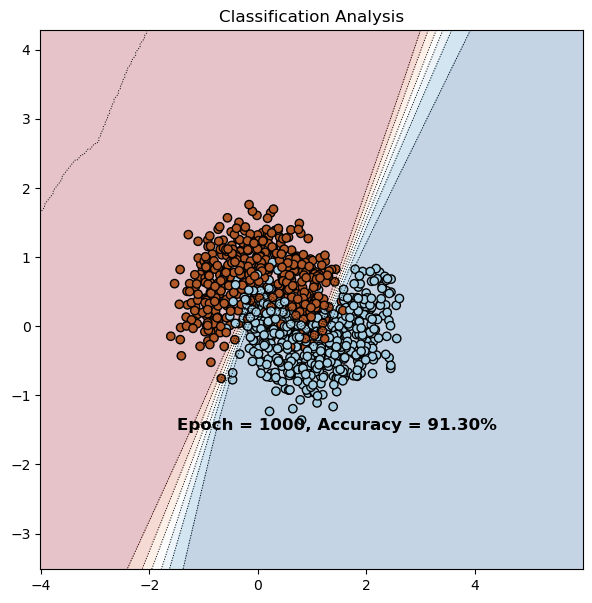

In [38]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=50)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(1000):
    optimizer.zero_grad()
    var_net.reset_kl_div()

    output = var_net(X).squeeze()
    loss = elbo(output, y, var_net)
    loss.backward()
    optimizer.step()

    if (epoch+1)%50==0:
      preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
      for i in range(NB_SAMPLES):
          preds[i] = var_net(X)
      pred = preds.mean(0).squeeze()
      accuracy = ((pred>=0.5) == y).float().mean()

      plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

# II.2 Monte Carlo Dropout

In [39]:
# Implement a MLP with dropout (p=0.2)
# We code MLP with 1 hidden layer and a dropout layer. The dropout layer is also activated during test time.

class MLP(nn.Module):
    """PyTorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = dropout_rate
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x, apply_dropout=False):
        x = F.relu(self.fc1(x))
        if apply_dropout:
            x = F.dropout(x, p=self.dropout, training=True)
        else:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)
    
# Note: When using this model for Monte Carlo predictions, you can call model.forward(x, apply_dropout=True)
# to ensure dropout is applied during inference, allowing you to perform multiple forward passes to simulate
# the predictive distribution.

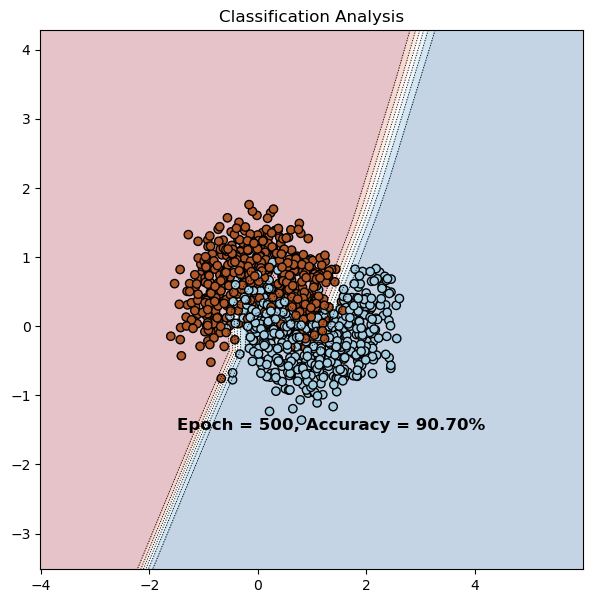

In [41]:
net = MLP(input_size=X.shape[1], hidden_size=50)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):

    optimizer.zero_grad()

    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch+1)%50==0:
      plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='classic')

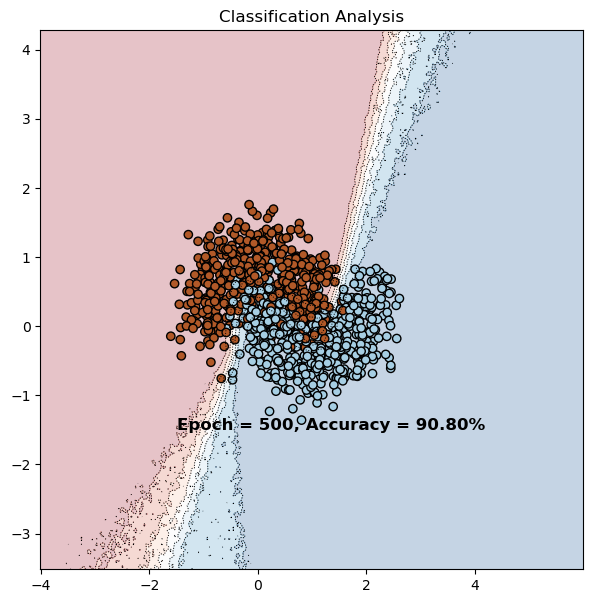

In [43]:
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):

    optimizer.zero_grad()

    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    if (epoch+1)%50==0:
      plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='mcdropout')